In [1]:
import datetime as dt

In [2]:
# --- Basic simulation settings ---
R0 = 2.0
seasonality_min_factor = 0.5
R_max = R0
R_min = seasonality_min_factor * R0

date_start = dt.date(2024, 10, 1)
date_stop = dt.date(2025, 6, 30)

In [3]:
from flumodelingsuite.seasonality import get_seasonal_transmission_balcan

In [4]:
dates, seasonality_vals = get_seasonal_transmission_balcan(
    date_start=date_start,
    date_stop=date_stop,
    date_tmax=dt.date(2025, 1, 1),
    date_tmin=dt.date(2025, 7, 1),
    R_min=R_min,
    R_max=R_max
)

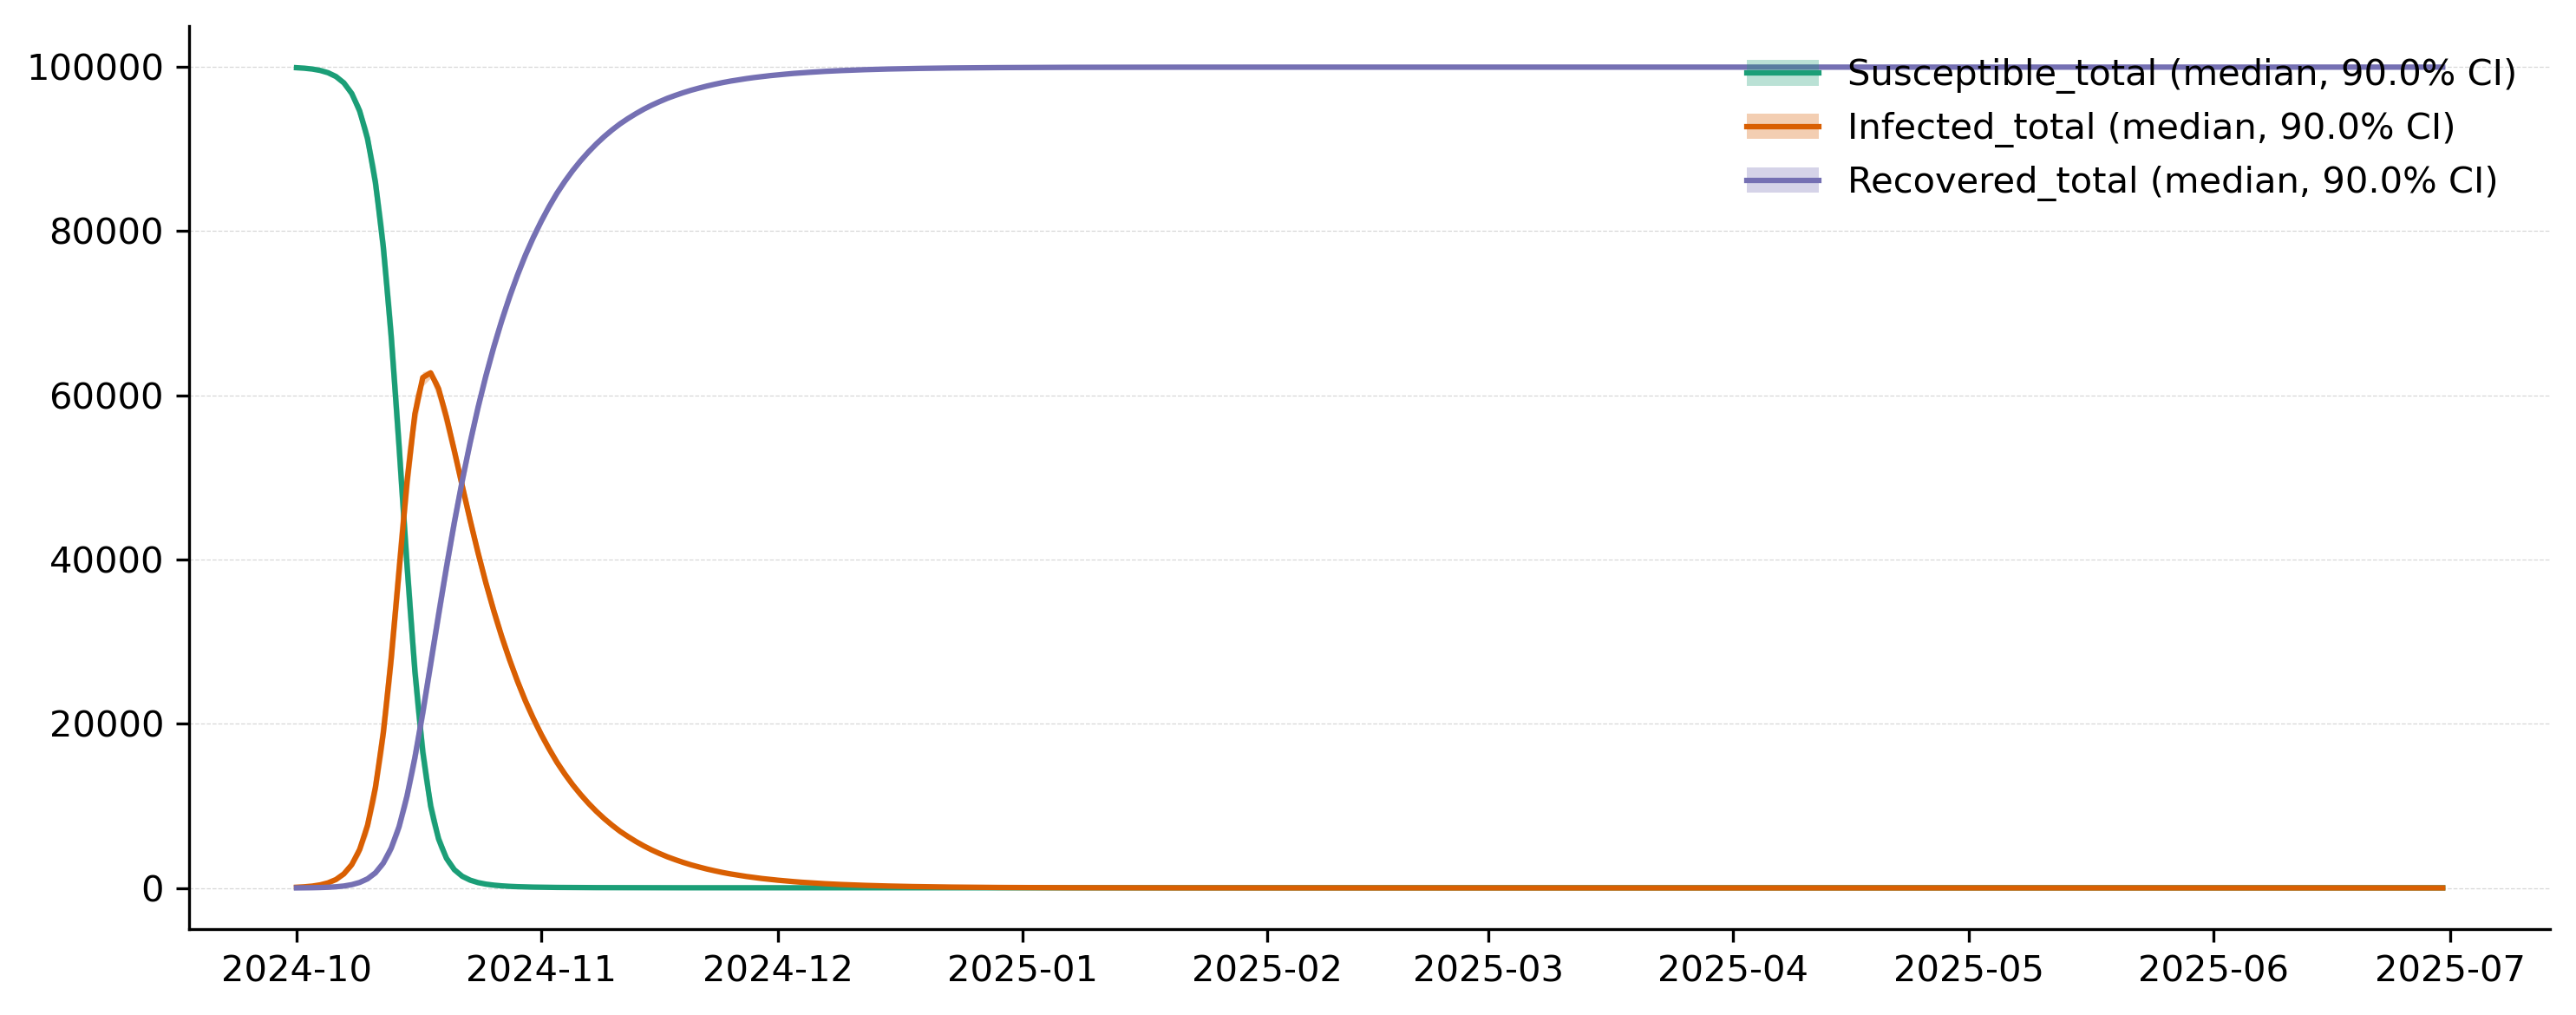

In [5]:
# Define model
from epydemix import load_predefined_model
from epydemix.visualization import plot_quantiles

model = load_predefined_model("SIR")

# Add time-varying transmission rate to the Epydemix model
model.add_parameter(parameter_name="transmission_rate", value=seasonality_vals)

# Run simulations
results = model.run_simulations(start_date=date_start, end_date=date_stop)

# Plot results
df_quantiles = results.get_quantiles_compartments()
plot_quantiles(df_quantiles, columns=["Susceptible_total", "Infected_total", "Recovered_total"], legend_loc="upper right");

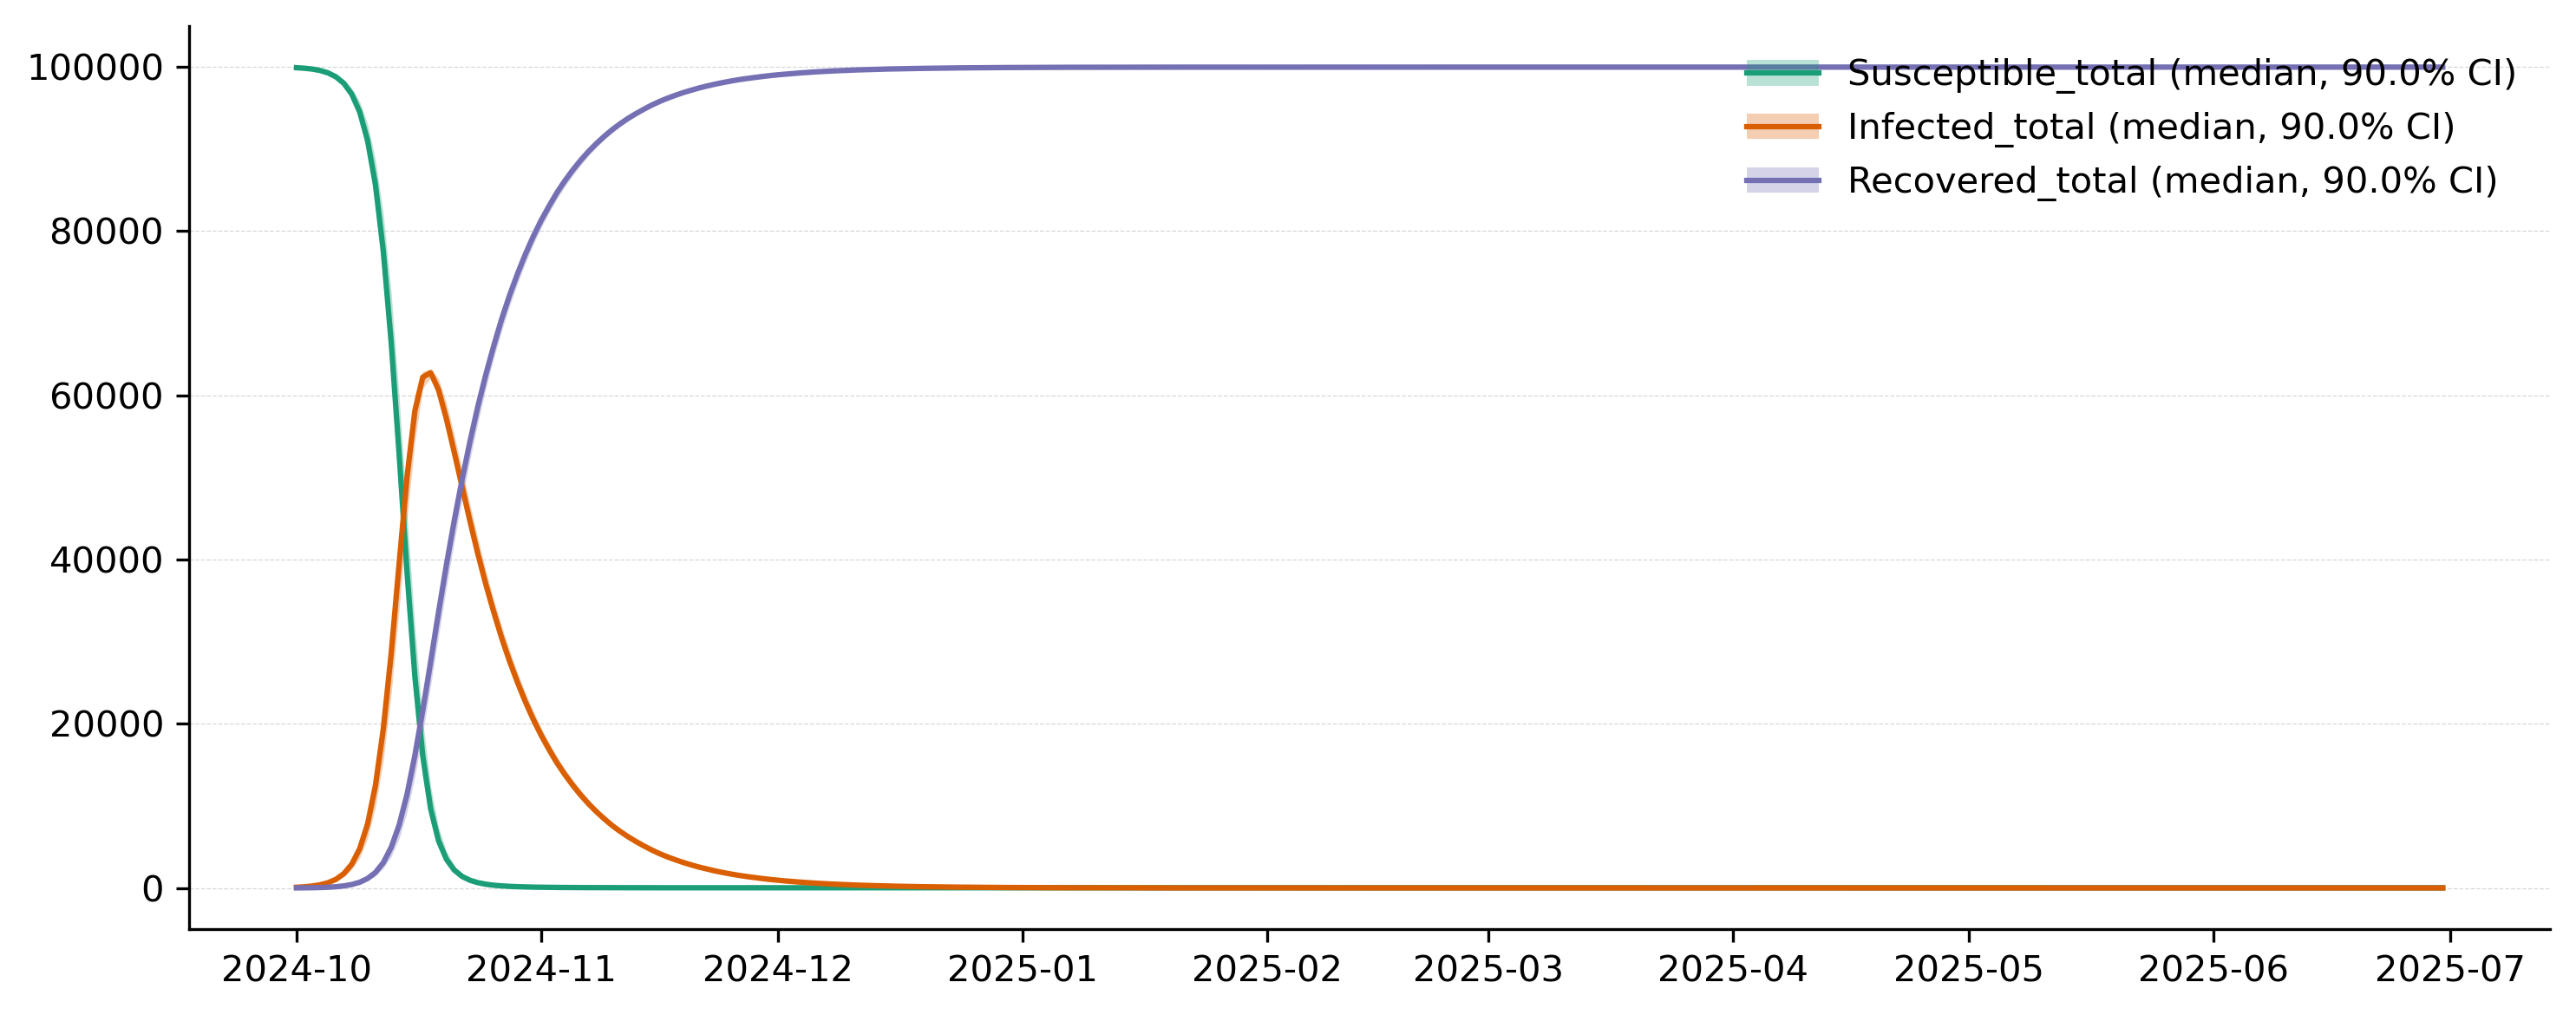

In [6]:
# Define model
from epydemix import load_predefined_model
from epydemix.visualization import plot_quantiles

model = load_predefined_model("SIR")

# Add time-varying transmission rate to the Epydemix model
model.add_parameter(parameter_name="transmission_rate", value=seasonality_vals)

# Run simulations
results = model.run_simulations(start_date=date_start, end_date=date_stop)

# Plot results
df_quantiles = results.get_quantiles_compartments()
plot_quantiles(df_quantiles, columns=["Susceptible_total", "Infected_total", "Recovered_total"], legend_loc="upper right");